# Введение
## Анализ временных рядов нужен для...

- сжатого **описание динамики** наблюдаемых процессов

- интерпретации динамики и **оценки импульсного отклика**

- **прогнозирования** и симулирования

- для решения задач **оптимального управления**

## Задача анализа временных рядов

Построение модели временного ряда для *текущего значения*  переменной $y_t$

* от её *предыстории* $y_{:t} = (y_{t-1}, y_{t-2}, \ldots)$ - значений переменной в предыдущие моменты времени

* *текущего значения* переменных $x_t$ (признаков объектов) и, возможно, *их предыстории* тоже


$$
    y_t \approx \text{модель}\bigl( t,\, y_{:t},\, x_t,\, x_{:t} \bigr)
\,. $$

<!-- Можно рассматривать задачи прогнозирования на несколько шагов вперёд от текущего значения, однако наиболее часто используется прогнозирование на один шаг вперёд. -->


## Отличия от прочих задач машинного обучения

* Данные последовательны:

  - порядок **времени** нужно строго соблюдать, чтобы не нарушать причинность

  * Большой упор на **экстраполяцию**, т.е. прогноз в будущее относительно имеющейся выборки

  - <span style="color:red;">**ВАЖНО**</span> убедиться, что <span style="color: red;"> **нет "утечки" информации "из будущего"** </span> при генерации фичей и построении модели - то есть, что для предсказания в более позднем времени используются **только** прошлые данные

  Поэтому признаки в модели могут зависеть только от
* **эндогенных** переменных (целевой переменной) $y_{t-1}, y_{t-2}, \ldots$, т.е. доступных на момент $t-1$ *включительно*;
* **экзогенных** переменных (признаков) $x_t, x_{t-1}, \ldots$, доступных на момент $t$ *включительно*.

## Постановка задачи

Сегодня мы рассмотрим обучающий пример - предсказание концентрации $CO_2$ в атмосфере. Тем не менее, подходы, рассмотренные в данной тетради применимы к реальным задачам предсказания временных рядов.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# библиотека для работы с массивами чисел
import numpy as np
# библиотека для работы с csv файлами
import pandas as pd
# библиотека для отрисовки графиков
%matplotlib inline
import matplotlib.pyplot as plt

# 1. Загрузка данных


Загрузим временной ряд концентрации $CO_2$ в атмосфере (основано на данных [отсюда](https://www.co2.earth/weekly-co2))

In [ ]:
!wget https://www.dropbox.com/s/h9e3yw97w58x7qa/seminar4_time_series.zip --quiet

In [ ]:
from zipfile import ZipFile

with ZipFile('seminar4_time_series.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [ ]:
dataset = pd.read_csv("./data/mauna_loa_atmospheric_c02.csv",
                      index_col=None, usecols=["date", "WMLCO2"])

In [ ]:
dataset.head()

,date,WMLCO2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


При загрузке временного ряда в Pandas нужно явно указывать на необходимость
превращения меток даты-времени из текстового в формат даты-времени.

* Это можно также указать при вызове `pd.read_csv`

In [ ]:
dataset["date"] = pd.to_datetime(dataset["date"], format="%Y-%m-%d")

Переименуем колонки

In [ ]:
dataset = dataset.rename(columns={"date": "дата", "WMLCO2": "концентрация CO2"})

Создадим индекс для загруженных данных: это будет **еженедельный периодический индекс**

У нас получатся данные с регулярной частотой

In [ ]:
dataset = dataset.set_index("дата").to_period("W")

In [ ]:
dataset.head()

,концентрация CO2
дата,
1958-03-24/1958-03-30,316.1
1958-03-31/1958-04-06,317.3
1958-04-07/1958-04-13,317.6
1958-04-14/1958-04-20,317.5
1958-04-21/1958-04-27,316.4


Нарисуем динамику ряда

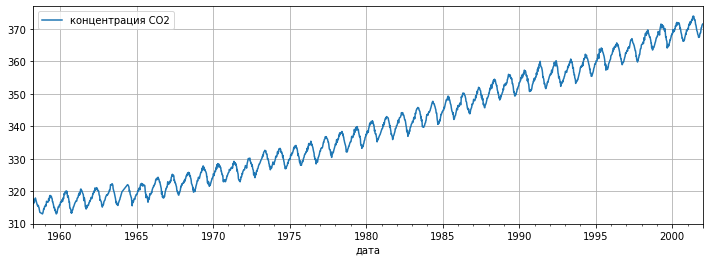

In [ ]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

Агрегируем еженедельные данные до ежемесячных

In [ ]:
dataset = dataset.to_timestamp()

dataset = dataset.resample("M").mean()

In [ ]:
dataset.head()

,концентрация CO2
дата,
1958-03-31,316.700
1958-04-30,317.100
1958-05-31,317.700
1958-06-30,315.800
1958-07-31,315.575


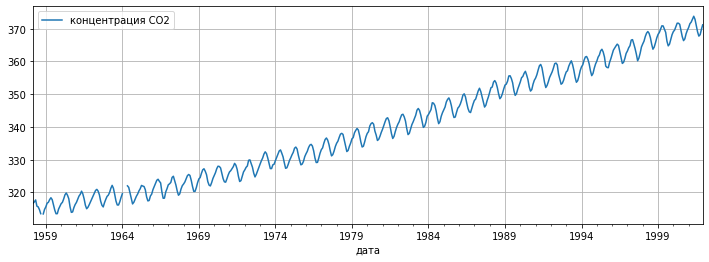

In [ ]:
dataset.plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

In [ ]:
dataset.shape

(526, 1)

Посмотрим на сводную статистику рядов

In [ ]:
print("Рядов {1}, Наблюдений {0}".format(*dataset.shape))

dataset.describe().T.head()

Рядов 1, Наблюдений 526


,count,mean,std,min,25%,50%,75%,max
концентрация CO2,522.0,339.794055,17.090851,313.425,324.185,337.9825,354.545,373.825


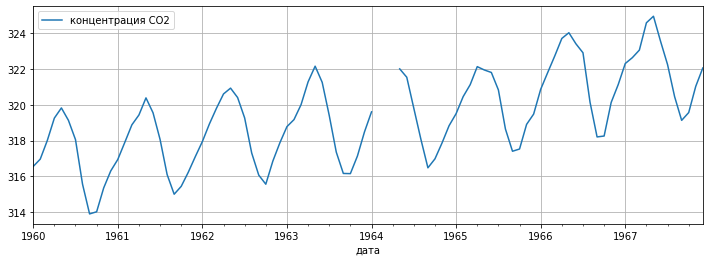

In [ ]:
dataset.loc["1960":"1967"].plot(figsize=(12, 4))

plt.grid(which="major", axis="both")

# 2. Обработка пропущенных значений


In [ ]:
# Функция slice позволяет вытаскивать интервалы из последовательностей
# На вход принимается старт и конец последовательности
maginfy_slice = slice("1960", "1967")

In [ ]:
maginfy_slice

slice('1960', '1967', None)

От пропущенных значений во временных рядах можно избавиться:

1) заполнив последним известным значением
  + **+** не заглядывает "в будущее"

  + **-** не может заполнить пустые значения в начале ряда

  - **-** не учитывает особенности ряда

2) с помощью интерполяции соседних наблюдаемых значений

  + **+** сглаживает скачки в значениях

  - **-** не позволяет заполнить пустые значения на концах ряда

  + **-** немного заглядывает "в будущее"

In [ ]:
dataset_linterp = dataset.interpolate(method='linear')

dataset_pinterp = dataset.interpolate(method='polynomial', order=2)

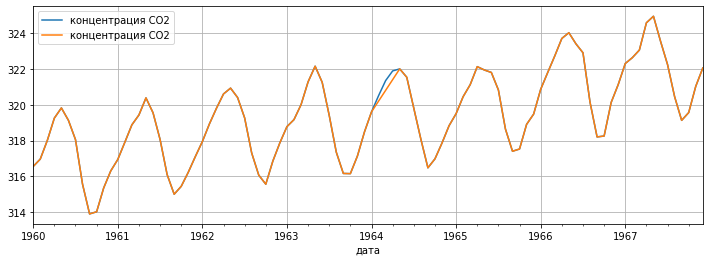

In [ ]:
ax = dataset_pinterp.loc[maginfy_slice].plot(figsize=(12, 4))

dataset_linterp.loc[maginfy_slice].plot(ax=ax)

plt.grid(which="major", axis="both")

3) просто исключить вовсе

  + **+** не привносит искажений в значения
  - **-** нарушает регулярность и относительную периодичность

  - **-** истощает выборку


# 3. Деление выборки на тренировочную и тестовую

In [ ]:
full_dataset = dataset_pinterp

Подготовим обучающую выборку и тестовую в пропорции 3 к 1

In [ ]:
holdout = full_dataset.loc["1991-01-01":]

dataset = full_dataset.loc[:"1990-12-31"]

print(len(dataset), len(holdout))

394 132


Явно сохраним границы отрезков

In [ ]:
holdout_slice = slice(*holdout.index[[0, -1]])

print("Обучающая выборка с {} по {}".format(*dataset.index[[0, -1]]))

print("Тестовая выборка с {} по {}".format(holdout_slice.start, holdout_slice.stop))

Обучающая выборка с 1958-03-31 00:00:00 по 1990-12-31 00:00:00
Тестовая выборка с 1991-01-31 00:00:00 по 2001-12-31 00:00:00


Выберем колонку

In [ ]:
target_column = "концентрация CO2"

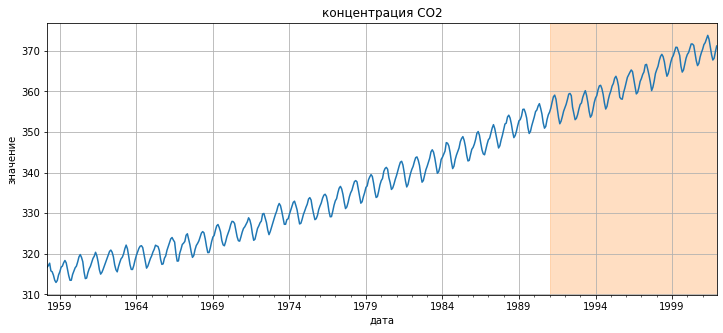

In [ ]:
# создадим и настроим холст
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Дата", ylabel="значение", title=target_column)

# нарисуем динамику всего ряда
full_dataset[target_column].plot(ax=ax)

# затемнение отложенного интервала
ax.axvspan(holdout_slice.start, holdout_slice.stop,
           color="C1", alpha=0.25, zorder=-99)

ax.grid(which="major", axis="both") ;


<br>

# 4. Свойство ...

**Стационарность** -- полезное свойство процесса, означающее, что:

> вероятностные взаимосвязи в наборе $(y_{t_1},\,\ldots,\,y_{t_m})$ ровно такие же, что и
в $(y_{t_1+s},\,\ldots,\,y_{t_m+s})$, для любого сдвига $s \neq 0$.

* нет **особых моментов времени**, когда изменяются статистические свойства наблюдений;

* закономерности устойчивы во времени и определяются только **отступом наблюдений друг относительно друга**;
  * среднее, дисперсия и автокорреляции не зависят от момента времени;

## ... которого нет

Случайные процессы, встречающиеся в реальных задачах, **практически всегда нестационарны**.

* средний уровень зависит от времени (в динамике есть тренд)
  - устойчивый рост ВВП
  - снижение добычи в скважине
  - зависимость от внешних факторов (экзогенных переменных)

* календарные события
  - государственные и религиозные праздники

* сезонная периодичность
  - внутридневная цикличность потребления электроэнергии
  - сезонные температуры
  - ежегодный пик месячной инфляции в январе-феврале 

* периоды спокойной динамики сменяются периодами относительно высокой волатильности
  - сильные возмущения на финансовых рынках во время кризиса

Соответственно большинство временных рядов, в особенности экономические, климатические и финансовые, нестационарны.

<br>

## 4.1 Визуализация и диагностика нестационарности 

(оставить только скользящие статистики сезонность и проблему)

Визуализация в анализе временных рядов позволяет:

- получить предварительное представление о корреляционных закономерностях

- выбрать целесообразную стратегию валидации

- прикинуть, есть ли в динамике ряда структурные изменения
  * скачки и разрывы
  * скопления интенсивных колебаний и периоды плавных движений

- провести диагностику нестационарности: наличие тренда, сезонности, пр.

In [ ]:
def diagnostics(series, window=250, fraction=0.25, lags=250):
    # скользящие статистики
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # грубая сезонность
    monthly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

### График скользящих статистик

Скользящие статистики ряда в окне длины $N$ дают понять есть ли изменения во времени

* **скользящее среднее:** среднего уровня ряда
$$
    m_t = \frac1{N} \sum_{s=t-N+1}^t y_s
\,; $$

* **скользящее стандартное отклонение:** разброс или волатильность
$$
    s_t = \sqrt{s^2_t}
        \,, \quad
    s^2_t = \frac1{N-1} \sum_{s=t-N+1}^t (y_s - m_t)^2
\,; $$

Ниже приведена процедура для удобного построения графиков диагностики.

In [ ]:
def rolling_diagnostics(series, window=500):
    rolling = series.rolling(window)

    # создадим и настроим холсты: верхний и нижний
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Скользящее среднее", xlabel="Дата", ylabel="значение")
    ax_bottom = fig.add_subplot(212, title="Скользящее стд. отклонение",
                                sharex=ax_top, xlabel="Дата", ylabel="стд. откл.")

    # нарисуем графики:
    # ряд и скользящее среднее
    rolling.mean().plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # скользящее стандартное отклонение
    rolling.std().plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")

    fig.tight_layout()
    return fig

По графикам скользящих статистик можно судить, что в динамике имеется тренд

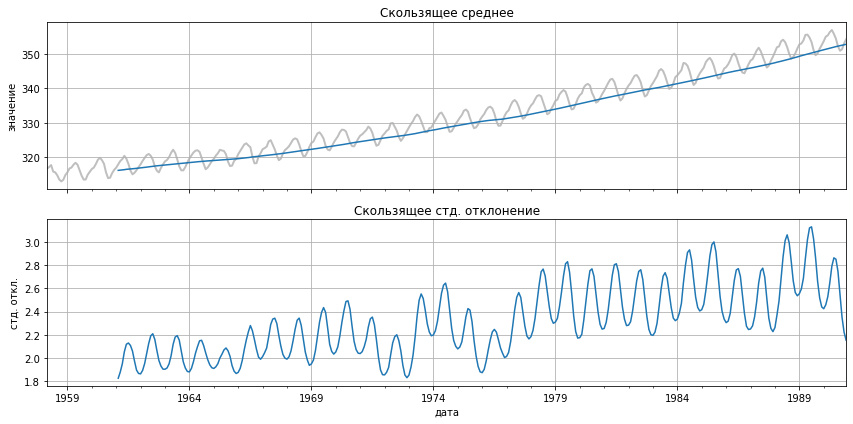

In [ ]:
rolling_diagnostics(dataset[target_column], window=36) ;

<br>

### Грубая оценка сезонности

Можно попробовать исследовать сезонность, например месячную или недельную.

* при оценке сезонности желательно, чтобы сезонные корректировки производились относительно тренда.

In [ ]:
def monthly_seasonality_diagnostics(series, fraction=0.66, period="month"):
    import statsmodels as sm
    import statsmodels.api
    # воспользуемся непараметрической локальной линейной регрессией для предварительной оценки тренда
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # сгруппируем по месяцам и вычислим среднее и стд. отклонение
    by = getattr(series.index, period, "month")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # создадим и настроим холсты: верхний и нижний
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Тренд", xlabel="Дата")
    ax_bottom = fig.add_subplot(212, title="Сезонность", xlabel=period)

    # нарисуем графики
    # ряд и тренд
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # сезонность и 90% нормальный доверительный интервал
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")


    fig.tight_layout()
    return fig

На графиках видно, что в динамике сезонная периодичность

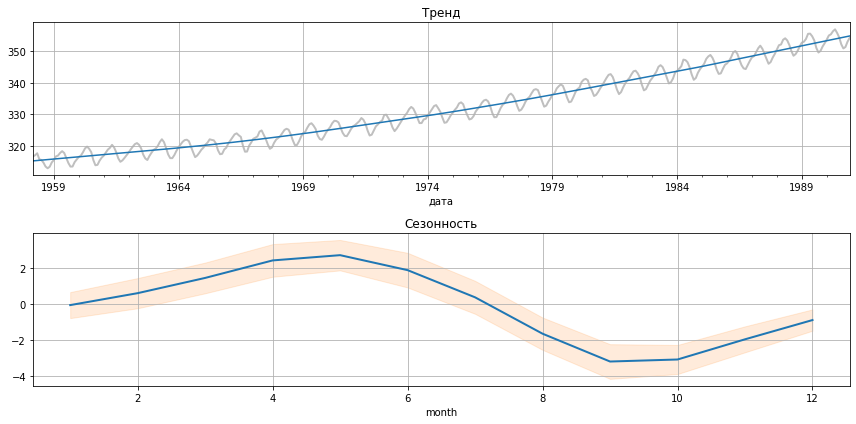

In [ ]:
monthly_seasonality_diagnostics(dataset[target_column], fraction=0.33, period="month");

<br>

### (Бонус) Полная и частная автокорреляция

Эти функции оценивают влияние наблюдения $h$ шагов на текущее наблюдение, однако делают это по-разному:

* **полная автокорреляция** $\rho_h$ <!-- ($y_t \sim y_{t-h}$) -->
  - отражает **совокупный** эффект $y_{t-h}$ на $y_t$ **через** влияние на все промежуточные $y_{t-j}$, $j=1,\,...,\,h-1$

* **частная автокорреляция** $\phi_h$ <!-- ($y_t \sim y_{t-1}, \ldots, y_{t-h}$) -->
  - показывает **чистый** эффект $y_{t-h}$ на $y_t$ **исключая** влияние на промежуточные $y_{t-j}$, $j=1,\,...,\,h-1$

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

Ниже приведена процедура для удобного построения графиков диагностики.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def correlation_diagnostics(series, lags=60):
    # создадим и настроим холсты: левый и правый
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Лаг", "ylim": (-1.1, 1.1)})

    # Нарисуем графики при помощи встроенных функций в statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Выборочная Автокорреляция", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Выборочная Частная Автокорреляция", marker=None)

    fig.tight_layout()
    return fig

Исследуем выборочные автокорреляции нашего ряда

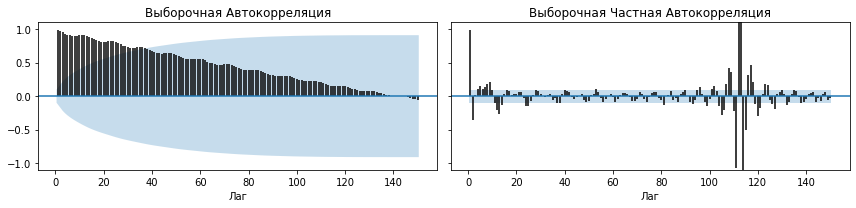

In [ ]:
correlation_diagnostics(dataset[target_column], lags=150);

* на *левом графике* автокорреляция малых лагов близка к $1.0$ и убывает достаточно медленно
* на *правом графике* статистически ненулевой чистый эффект имеется у наблюдения с лагом 1

Это симптомы самого типичного вида нестационарности -- т.н. наличие зависимости вида $y_t = y_{t-1} + \ldots$.

Это означает, что наблюдается сильная зависимость от истории процесса.

<br>

## 4.2 Проблема

**Без стационарности** моделировать ряды очень тяжело

* нет устойчивых инвариантных закономерностей, пригодных для моделирования и прогнозирования

<br>

## 4.3 Что же делать?

Если **приблизить** ряд как можно сильнее к стационарному, **учитывая тренд, сезонность и иные портящие факторы**

то **можно надеяться на** более-менее успешное **моделирование и решение** прикладных задач.

<br>

# 5. Построение модели временного ряда

Построение пригодных моделей временных рядов сложнее, чем решение задачи регрессии

### Ключевые этапы

`I`. Делаем ряд **стационарным**
    
  $y \mapsto \log{y}$
  

 Добавляем:

  * смещение и масштабирование

  * взятие последовательных или сезонных разностей

  * выделение и вычитание тренда / сезонности

  * определение особых дат или событий
    - государственные и религиозные праздники
    - моменты замены оборудования
    - факты пресечения границы пород

  * и т.д.

<span style="color:red;">**ВАЖНО**</span> обратные преобразования нужно применять к прогнозам в **обратном** порядке!


`II`. **Создаем модель**
  

`III`. **Визуализация остатков** 
  * смотрим на динамику ряда, на полную и частную автокорреляции, скользящие статистики

  * проверяем остатки на требования спецификации модели

    - *удовлетворительное* отсутствие автокорреляции

    - *удовлетворительно* постоянные среднее и дисперсия

`IV`. **Валидируем модель**

  * вычисление **прогнозов на отложенной** выборке

Стратегия моделирования временных рядов основана на идеях, описанных в работе

* Box, George; Jenkins, Gwilym (1970). *Time Series Analysis: Forecasting and Control.* San Francisco: Holden-Day.

<br>

### Все модели ошибочны, но некоторые -- полезны

На практике модель временного ряда необходимо обновлять и обучать заново, когда накопится достаточный объём новых данных.



## `I-II-III` Остационаривание - Оценка - Визуализация

### Преобразования

Для нашей задачи применение классический преобразований не дает улучшения предсказаний, но обычно взятие логарифмов делает оценку параметров модели устойчивее.

### Модель тренда и сезонности Хольта-Уинтерса


Обобщённое сглаживание с локальными линейными трендами и сезонностью

* **+** простая модель, основанная на простых идеях

* **-** обычно выделенный тренд немного "запаздывает"

* **-** детерминированный период сезонности задаваемый вручную

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
exp_smooth = ExponentialSmoothing(dataset,
                                  trend="add",         # аддитивный тренд
                                  seasonal="add",      # аддитивная сезонность
                                  seasonal_periods=12)

 # обучение - подбор параметров статистической модели
exp_smooth_fitted = exp_smooth.fit(remove_bias=True)

Посмотрим на подгонку

In [ ]:
series_fitted = exp_smooth_fitted.fittedvalues.to_frame()

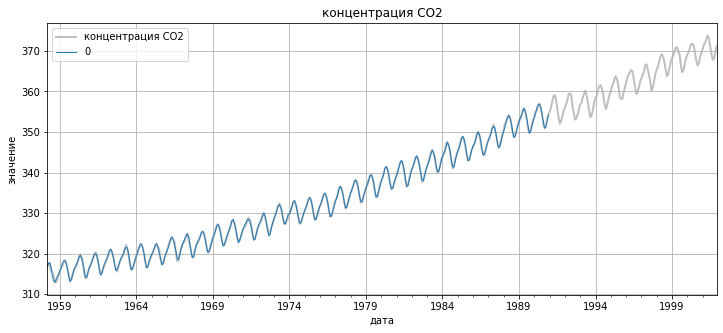

In [ ]:
# создадим и настроим холст
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Дата", ylabel="значение", title=target_column)

# нарисуем динамику всего ряда
full_dataset[target_column].plot(ax=ax, color="black",
                                 lw=2, alpha=.25, zorder=-10)

series_fitted.plot(ax=ax, color="C0", lw=1, alpha=1.0,
                         label="оценка H-W на трейне")

ax.grid(which="major", axis="both")
ax.legend() ;



**ВЫВОД** Модель экспоненциального сглаживания может быть **полезной** для прогнозирования этого процесса.

<br>

## `IV`. Валидируем модель

### Прогнозирование

Оставить rmse, r2_score + MAPE

**Цель** -- построить траекторию прогнозов будущих значений на горизонте $h$ по доступной информации на момент $t$ *включительно*.

Если в модели временного ряда участвуют **экзогенные** переменные, то обязательно требуется
* **известная будущая траектория** экзогенных переменных $x_{t+h},\,x_{t+h-1},\,\ldots$

  - прогнозы $x_t$ из других моделей (в которых не должен использоваться $y_t$)

#### Динамическое или вне-выборочное

Прогнозы $\hat{y}_{s\mid t}$ для $s = t+1,\,\ldots,\, t+h$ вычисляются по

* траектории **экзогенных** переменных до момента $s$ *включительно* ($x_s,\,x_{s-1},\,\ldots$)

* предыстории прогнозов $\hat{y}_{j\mid t}$ для $j = s-1,\,\ldots,\,t,\,t-1,\,\ldots$, причём $\hat{y}_{j\mid t} = y_j$ если $j\leq t$ -- используется фактическое историческое значение.

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \color{blue}{\hat{y}_{t+1\mid t}}
  , \color{gray}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \color{blue}{\hat{y}_{t+2\mid t}}
  , \ldots
  , \color{gray}{\hat{y}_{t+h-1\mid t}}
  , \color{gray}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        \,\,\Big ]
        \,\, \hat{y}_{t+1\mid t}
        , \hat{y}_{t+2\mid t}
        , \ldots
        , \hat{y}_{t+h-1\mid t}
      }}^{}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  \,\,\Big ]
  \,\, \hat{y}_{t+1\mid t}
  , \hat{y}_{t+2\mid t}
  , \ldots
  , \hat{y}_{t+h-1\mid t}
  , \color{blue}{\hat{y}_{t+h\mid t}}
  , \ldots
\end{aligned}

#### Статическое или внутри-выборочное

Вычисляются последовательные одношаговые динамические прогнозы
$\tilde{y}_s = \hat{y}_{s\mid s-1}$ для $s=t+1,\,\ldots,\,t+h$

- должна быть доступна **траектория значений** эндогенных переменных $y_t$ (*фактических*);

Полезно
- для валидации предобученной модели на известном датасете

\begin{aligned}
  & t+1\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
      }}^{\color{blue}{\hat{y}_{t+1\mid t}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , \color{red}{y_{t+1}}
  , \color{gray}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+2\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
      }}^{\color{blue}{\hat{y}_{t+2\mid t+1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , \color{red}{y_{t+2}}
  , \ldots
  , \color{gray}{y_{t+h-1}}
  , \color{gray}{y_{t+h}}
  , \ldots
\end{aligned}

\begin{aligned}
  & t+h\colon
  &
  \rlap{\overbrace{
      \phantom{
        \ldots
        , y_{t-2}
        , y_{t-1}
        , y_{t  }
        , y_{t+1}
        , y_{t+2}
        , \ldots
        , y_{t+h-1}
      }}^{\color{blue}{\hat{y}_{t+h\mid t+h-1}}}
    }
    \ldots
  , y_{t-2}
  , y_{t-1}
  , y_{t  }
  , y_{t+1}
  , y_{t+2}
  , \ldots
  , y_{t+h-1}
  , \color{red}{y_{t+h}}
  , \ldots
\end{aligned}

<br>

Будем оценивать точность прогноза по этим метрикам

$$
    RMSE(y, \hat{y}) = \sqrt{MSE(y, \hat{y})}
\,. $$

In [ ]:
def root_mean_squared_error(*args, **kwargs):
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(*args, **kwargs))

$$ 
    MAPE(y, \hat{y})
        = \frac1{m} \sum_{i=1}^m
            \frac{\lvert y_i - \hat{y}_i \rvert}{\lvert y_i \rvert}
\,.$$

In [ ]:
def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean(axis=0) * 100

$$
    R^2(y, \hat{y})
        = 1- \frac{\sum_{i=1}^m (y_i - \hat{y}_i)^2}{\sum_{i=1}^m (y_i - \bar{y})^2}
\,. $$

In [ ]:
from sklearn.metrics import r2_score

Соберём их в список

In [ ]:
scorers = [

    ("rmse", root_mean_squared_error),
    ("r2", r2_score),
    ("mape", mean_absolute_percent_error)
]

Посмотрим на **динамический** прогноз на $240$ месяцев вперёд

In [ ]:
# Получаем прогноз в будущее на 240 месяцев
exp_forecast = exp_smooth_fitted.forecast(steps=240).to_frame()

exp_forecast = pd.DataFrame(exp_forecast,
                            columns=exp_forecast.columns,
                            index=exp_forecast.index)

In [ ]:
exp_forecast.head()

,0
1991-01-31,355.194266
1991-02-28,355.979051
1991-03-31,356.954437
1991-04-30,358.048132
1991-05-31,358.460765


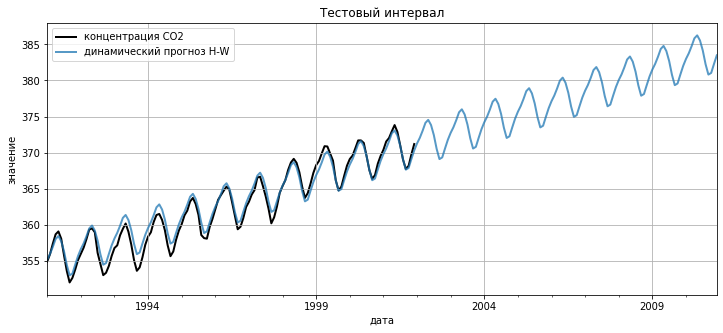

In [ ]:
# создадим и настроим холст
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, xlabel="Дата", ylabel="значение", title="Тестовый интервал")

# нарисуем динамику
holdout[target_column].plot(ax=ax, color="black", lw=2, alpha=1., zorder=-10)

exp_forecast[0].plot(ax=ax, color="C0", lw=2, alpha=0.75, label="динамический прогноз H-W")

ax.grid(which="major", axis="both")
ax.legend() ;

In [ ]:
holdout[target_column]

дата
1991-01-31    354.925
1991-02-28    355.950
1991-03-31    357.400
1991-04-30    358.700
1991-05-31    359.100
               ...   
2001-08-31    369.050
2001-09-30    367.750
2001-10-31    368.180
2001-11-30    369.775
2001-12-31    371.200
Freq: M, Name: концентрация CO2, Length: 132, dtype: float64

Рассчитаем метрики

In [ ]:
for name, metric in scorers:
  print(name)
  print(metric(holdout[target_column], exp_forecast.iloc[:len(holdout), 0]))


rmse
0.952907812421045
r2
0.9706783831089344
mape
0.22175097086189044


Сравним с простейшим бейзлайном -- **прогноз последним известным значением**

In [ ]:
last_known_forecast = full_dataset.shift(1).loc[holdout_slice]

**Упражение**: посчитайте метрики качества для модели бейзлайна

In [ ]:
# YOUR_CODE
for name, metric in scorers:
    print(name)
    print(metric(holdout[target_column], last_known_forecast.iloc[:len(holdout), 0]))

rmse
1.2751605662413534
r2
0.9474931593080971
mape
0.31507572424226127


# Выводы


**На этом семинаре мы**

* Рассмотрели задачу предсказания для временных рядов
* Изучили способы заполнения пропущенных данных во временных рядах
* Рассмотрели задачу "остационаривания" временного ряда
* Познакомились с библиотекой со статистическими моделями `statsmodels`
* Обучили предсказательную модель для временных рядов
* Научились валидировать модели временных рядов.

---

